In [1]:
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Script to set ensemsble dictionary with Latin Hypercube Sampling
# Mikayla Pascual 07/22/22
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#import 
from MatlabFuncs import *
from model import *
from loadmodel import *
from os.path import exists
import lhsmdu
import numpy as np
import pickle

In [2]:
### frontal forcings ###
#from frontalforcingsrignot import frontalforcingsrignot
#md.frontalforcings = frontalforcingsrignot()
#md.frontalforcings.subglacial_discharge = 2.6 * np.ones(md.mesh.numberofvertices)
#md.frontalforcings.thermalforcing = 15.7 * np.ones(md.mesh.numberofvertices)

In [14]:
### basal sliding ###
md.basalforcings

   basal forcings parameters:
         groundedice_melting_...: N/A             -- basal melting rate (positive if melting) [m/yr]
         floatingice_melting_...: N/A             -- basal melting rate (positive if melting) [m/yr]
         geothermalflux         : N/A             -- geothermal heat flux [W/m^2]

In [11]:
### ice temperature ###
md.materials.rheology_B

   Materials:
         rho_ice                : 917.0           -- ice density [kg/m^3]
         rho_water              : 1023.0          -- water density [kg/m^3]
         rho_freshwater         : 1000.0          -- fresh water density [kg/m^3]
         mu_water               : 0.001787        -- water viscosity [Ns/m^2]
         heatcapacity           : 2093.0          -- heat capacity [J/kg/K]
         thermalconductivity    : 2.4             -- ice thermal conductivity [W/m/K]
         temperateiceconducti...: 0.24            -- temperate ice thermal conductivity [W/m/K]
         effectiveconductivit...: 1               -- computation of effectiveconductivity: (0) arithmetic mean, (1) harmonic mean, (2) geometric mean (default)
         meltingpoint           : 273.15          -- melting point of ice at 1atm in K
         latentheat             : 334000.0        -- latent heat of fusion [J/m^3]
         beta                   : 9.8e-08         -- rate of change of melting point wit

In [2]:
### calving forcings ###
# We set the calving model (no moving front ... spclevelset is actually ignored)
from calvingvonmises import calvingvonmises
md.calving = calvingvonmises()
md.calving.stress_threshold_groundedice = md.calving.stress_threshold_groundedice * 0.5

In [21]:
# Set Latin Hypercube sampling parameters
k = lhsmdu.sample(3, 10) # Latin Hypercube Sampling with multi-dimensional uniformity, 
                        # 3 variables with 10 samples each
k = np.array(k)
# collect -50% to 50% range
#k = (k * 0.7) - 0.2
k = k - 0.5
k

array([[-0.06440273, -0.42421539,  0.20143935,  0.01160726,  0.30460026,
        -0.19592712,  0.48554606,  0.17036579, -0.35258262, -0.29021658],
       [ 0.04916159, -0.15265282,  0.11732019, -0.25661484, -0.06014953,
         0.36158501,  0.46350937,  0.2045304 , -0.46253874, -0.33741401],
       [-0.44968637,  0.48564898,  0.16586936,  0.01629344,  0.30705687,
        -0.33575807, -0.29734887,  0.25857756, -0.10597698, -0.04245258]])

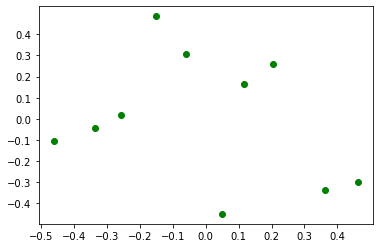

In [26]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(-0.5,0.5,0.1))
ax.set_yticks(np.arange(-0.5,0.5,0.1))
plt.scatter(k[0], k[1], color="g", label="LHS-MDU")
plt.show()

In [12]:
# change initial model parameters to proportional LHS output
sd_after = 2.6 * k[0]
tf_after = 15.7 * k[1]
calve_after = md.calving.stress_threshold_groundedice + md.calving.stress_threshold_groundedice*k[2]

In [27]:
# Create 10 ensembles with parameters from [0], [1], [2], ..., [9]
lhs_params_for_ens = {
    'basal_after' : k[0],
    'ice_temp_after' : k[1],
    'calve_after' : k[2]
} 
lhs_params_for_ens

# ens needs to match LHS sample number
ens = list(range(0, 10))

ens_dict = {}
for i in range(len(ens)):
    trial_name = 'Trial' + str(i)
    res = dict()
    for sub in lhs_params_for_ens:
        res[sub] = lhs_params_for_ens[sub][i]
    ens_dict[trial_name] = res
ens_dict

{'Trial0': {'basal_after': -0.0644027321348738,
  'ice_temp_after': 0.0491615875116832,
  'calve_after': -0.44968637414199125},
 'Trial1': {'basal_after': -0.4242153889535631,
  'ice_temp_after': -0.15265282292194343,
  'calve_after': 0.4856489841188323},
 'Trial2': {'basal_after': 0.20143934886297554,
  'ice_temp_after': 0.11732018699100144,
  'calve_after': 0.1658693631618945},
 'Trial3': {'basal_after': 0.011607264050691679,
  'ice_temp_after': -0.2566148350762027,
  'calve_after': 0.016293442708142925},
 'Trial4': {'basal_after': 0.30460026420217534,
  'ice_temp_after': -0.06014952656026262,
  'calve_after': 0.30705687474004306},
 'Trial5': {'basal_after': -0.195927119768103,
  'ice_temp_after': 0.3615850098052217,
  'calve_after': -0.3357580721793684},
 'Trial6': {'basal_after': 0.48554605840110077,
  'ice_temp_after': 0.46350936508676444,
  'calve_after': -0.2973488689458378},
 'Trial7': {'basal_after': 0.17036578593800233,
  'ice_temp_after': 0.20453040097720443,
  'calve_after'

In [28]:
# save output
with open('ens_dict.pickle', 'wb') as f:
    # Pickle the 'data' dictionary 
    pickle.dump(ens_dict, f)